In [29]:
from utils.converters import df_to_XY
from utils.readers import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Read data
## Grouping M&A volume by month

In [30]:
def reconfigure_vol_df(df):
    df['Date'] = df['Date'].dt.to_period('M')
    out = {'date': [], 'vol': []}
    for y in range(2000, 2022):
        for m in range(1, 13):
            i = f"{y}-{m}"
            d = df[df['Date'] == i]
            out['date'].append(i)
            out['vol'].append(len(d))
    df = pd.DataFrame(data=out['vol'], index=out['date'], columns=['vol'])
    df.index.name = 'date'
    return df

In [31]:
"""Groups M&A transactions of UK being the acquirer by month"""
acquirer_uk = read_acquirer_uk()
acquirer_uk = reconfigure_vol_df(acquirer_uk)

In [32]:
"""Groups M&A transactions of UK being the target by month"""
target_uk= read_target_uk()
target_uk = reconfigure_vol_df(target_uk)

In [33]:
"""Net M&A volume"""
net_vol_monthly = target_uk + acquirer_uk

In [34]:
# net_vol_monthly.index.values.astype(str)

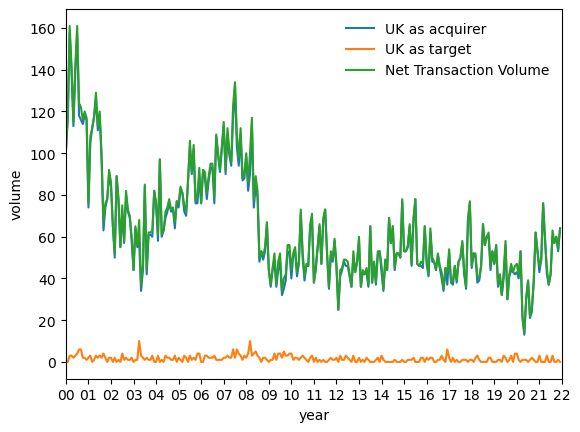

In [35]:
ax = plt.gca()
ax.plot(acquirer_uk.index.values.astype(str), acquirer_uk.vol, label='UK as acquirer')
ax.plot(target_uk.index.values.astype(str), target_uk.vol, label='UK as target')
ax.plot(net_vol_monthly.index.values.astype(str), net_vol_monthly.vol, label='Net Transaction Volume')
ax.set_xticks([])
ax.legend(frameon=False)
ax.set_xticks(ticks=range(0, 265, 12), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
ax.set_xlim(0, 264)
ax.set_ylabel('volume')
ax.set_xlabel('year');

## GDP

## Only quarterly data available

In [36]:
gdp_quarter = read_gdp()
until = '2022-01'
gdp_quarter['Date'] = gdp_quarter['Date'].dt.to_period('M')
gdp_quarter = gdp_quarter[gdp_quarter['Date'] < until]
# gdp_quarter

In [37]:
"""Regrouping transactions by cumulative of 3 months and quarterly data of other explanatory variables: SMI, EXUSUK, and SMI."""
res = []
for i in range(int(len(net_vol_monthly)/3)):
    s = net_vol_monthly[3*i: 3*(i+1)]
    res.append(s.vol.sum())
gdp_quarter['vol'] = res
# gdp_quarter

## Variables

In [38]:
until = '2022-01'
var_monthly = read_variable_monthly()
var_monthly['Date'] = var_monthly['Date'].dt.to_period('M')
var_monthly = var_monthly[var_monthly['Date'] < until]
var_monthly['vol'] = net_vol_monthly.vol.values

res = {'EXUSUK': [], 'Interest_Rate': [], 'SMI': []}
for i in range(int(len(var_monthly)/3)):
    s = var_monthly[3*i: 3*(i+1)]
    res['EXUSUK'].append(s.EXUSUK.mean())
    res['Interest_Rate'].append(s['Interest_Rate'].mean())
    res['SMI'].append(s.SMI.mean())
gdp_quarter['EXUSUK'] = res['EXUSUK']
gdp_quarter['Interest_Rate'] = res['Interest_Rate']
gdp_quarter['SMI'] = res['SMI']
# gdp_quarter

# var_monthly['vol']

In [55]:
# var_monthly.vol = var_monthly.vol.pct_change().values
var_monthly.drop(index=var_monthly.index[0], axis=0, inplace=True)

# Regression

In [56]:
"""To determine the effect the Brexit, we refer to the day of UK announcing its plan to exit the European Union as the separation date"""

x_index = ['EXUSUK', 'Interest_Rate', 'SMI']
y_index = ['vol']

data = var_monthly
sep = '2016-6'
data_before = data[data.Date < sep]
data_after = data[data.Date > sep]

"""Regressing on historical transactions between Jan.2000 to June.2016"""
X_train, Y_train = df_to_XY(data_before, xkeys=x_index, ykeys=y_index)
X_train = sm.add_constant(X_train)

"""Regressing on historical transactions between June.2016 to Nov.2021"""
X_test, Y_test = df_to_XY(data_after, xkeys=x_index, ykeys=y_index)
X_test = sm.add_constant(X_test)

model_before = LinearRegression().fit(X_train, Y_train)
model_after = LinearRegression().fit(X_test, Y_test)

"""R square of model before and after the announcement of Brexit"""
model_before.score(X_train, Y_train), model_after.score(X_test, Y_test)


(0.0025877729492588264, 0.014059546774956355)

In [57]:
model_before.coef_

array([[ 0.00000000e+00,  3.19438862e-02, -6.19003766e-03,
        -2.84264856e-05]])

In [58]:
model_before.intercept_

array([0.02467829])

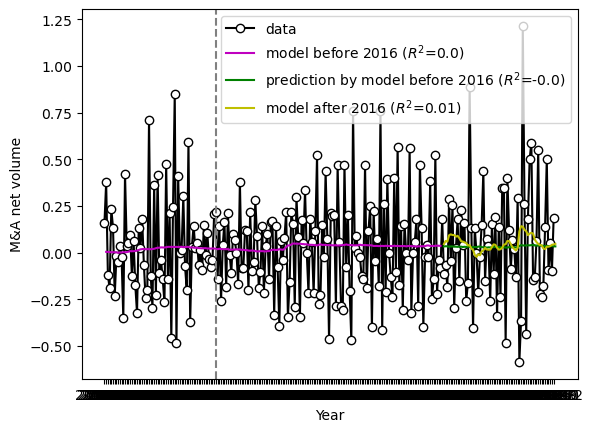

In [59]:
ax = plt.gca()

x_data = data.Date.astype(str)
ax.plot(x_data, data.vol, marker='o', color='k', mfc='white', ls='-', label='data')

Y_train_pred = model_before.predict(X_train)
x_data_before = data_before.index
r = r2_score(Y_train, Y_train_pred,)
ax.plot(x_data_before, Y_train_pred, color='m',
        label=f'model before 2016 ($R^2$={round(r, 2)})')

x_data_after = data_after.index
Y_test_pred = model_before.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='g',
        label=f'prediction by model before 2016 ($R^2$={round(r, 2)})')


"""Using model based on data before June.2016 to predict for 2016 - 2021"""
Y_test_pred = model_after.predict(X_test)
r = r2_score(Y_test, Y_test_pred)
ax.plot(x_data_after, Y_test_pred, color='y',
        label=f'model after 2016 ($R^2$={round(r, 2)})')

ax.axvline(65, ls='--', color='gray')
# plt.xticks(ticks=range(0, 89, 4), labels=[str(i).zfill(2) for i in range(0, 23, 1)])
# ax.set_xlim(0, 88)
ax.set_ylabel('M&A net volume')
ax.set_xlabel('Year')
# ax.set_ylim(0, -500)
ax.legend(loc=0, frameon=True);

In [44]:
Y_test_pred_model_before = model_before.predict(X_test)
Y_test_pred_model_after = model_after.predict(X_test)

(array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          1.,  2.,  0.,  1.,  1.,  2.,  6.,  5.,  8.,  7.,  8.,  9.,  3.,
          6.,  3.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  4.,  3.,  3.,  9.,  9.,
         13., 11.,  7.,  3.]]),
 array([-2.55778923, -2.45983754, -2.36188584, -2.26393415, -2.16598245,
        -2.06803075, -1.97007906, -1.87212736, -1.77417566, -1.67622397,
        -1.57827227, -1.48032058, -1.38236888, -1.28441718, -1.18646549,
        -1.08851379, -0.99056209, -0.8926104 , -0.7946587 , -0.69670701,
        -0.59875531, -0.50080361, -0.40285192, -0.30490022, -0.20694852,
        -0.10899683, -0.01104513,  0.08690656,  0.18485826,  0.28280996,
         0.38076165]),
 <a list of 2 BarContainer objects>)

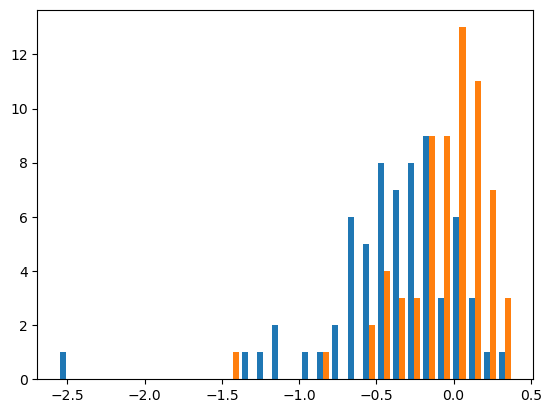

In [45]:
error_test_model_before = (Y_test - Y_test_pred_model_before) / Y_test
error_test_model_after = (Y_test - Y_test_pred_model_after) / Y_test
ax = plt.gca()

bins = np.linspace(-2, 0.5, 100)
plt.hist([error_test_model_before.reshape(-1), error_test_model_after.reshape(-1)], bins=30)

## Model before announcement of Brexit

In [46]:
"""Summary of model based on historical data before 2016"""
multi_model_before = sm.GLS(Y_train, X_train).fit()
X_train
multi_model_before.summary()
# """[X1:'EXUSUK', X2:'Interest_Rate', X3:'SMI', X4:'UK_GDP']"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.737
Model:                            GLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     180.2
Date:                Wed, 23 Nov 2022   Prob (F-statistic):           1.04e-55
Time:                        09:30:19   Log-Likelihood:                -798.05
No. Observations:                 197   AIC:                             1604.
Df Residuals:                     193   BIC:                             1617.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.7550     10.336      7.233      0.000      54.370      95.140
x1           -56.2284      8.292     -6.781      0.000     -72.582     -39.874
x2            11.0246      0.519     21.262      0.000      10.002      12.047
x3             0.0504      0.006      8.454      0.000       0.039       0.062
==============================================================================
Omnibus:                        6.899   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.032   Jarque-Bera (JB):               10.807
Skew:                           0.123   Prob(JB):                      0.00450
Kurtosis:                       4.121   Cond. No.                     1.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
fig_before1 = sm.graphics.plot_regress_exog(multi_model_before, 1)

AttributeError: 'GLS' object has no attribute 'weights'

<Figure size 640x480 with 0 Axes>

In [ ]:
fig_before2 = sm.graphics.plot_regress_exog(multi_model_before, 2)

In [ ]:
fig_before3 = sm.graphics.plot_regress_exog(multi_model_before, 3)

In [ ]:
print(multi_model_before.summary())
# ['Interest_Rate', 'SMI', 'UK_GDP']

In [ ]:
sm.add_constant(X_train)

In [ ]:
multi_model_before.model.exog

In [ ]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name, test)

In [ ]:
VIF = [variance_inflation_factor(multi_model_before.model.exog, i) for i in range(1,4)]
VIF_data = pd.DataFrame(VIF, columns=['VIF'])
VIF_data.index = ['EXUSUK', 'Interest_Rate', 'SMI']
VIF_data

## Model after announcement of Brexit

In [ ]:
multi_model_after = sm.OLS(Y_test, X_test).fit()
multi_model_after.summary()

In [ ]:
name_after = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_after = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name_after, test_after)

In [ ]:
VIF_after = [variance_inflation_factor(multi_model_after.model.exog, i) for i in range(1,5)]
VIF_data_after = pd.DataFrame(VIF_after, columns=['VIF'])
VIF_data_after.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_after

In [ ]:
fig_after1 = sm.graphics.plot_regress_exog(multi_model_after, 1)

In [ ]:
fig_after2 = sm.graphics.plot_regress_exog(multi_model_after, 2)

In [ ]:
fig_after3 = sm.graphics.plot_regress_exog(multi_model_after, 3)

In [ ]:
fig_after4 = sm.graphics.plot_regress_exog(multi_model_after, 4)

## Overall Model from 2000 to 2021

In [ ]:
X_all, Y_all = df_to_XY(gdp_quarter, xkeys=x_index, ykeys=y_index)
X_all = sm.add_constant(X_all)
overall_model_ols = sm.OLS(Y_all, X_all).fit()
overall_model_ols.summary()

In [ ]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(overall_model_ols.resid, overall_model_ols.model.exog)
lzip(name, test)

In [ ]:
VIF_overall = [variance_inflation_factor(overall_model_ols.model.exog, i) for i in range(1,5)]
VIF_data_over = pd.DataFrame(VIF_overall, columns=['VIF'])
VIF_data_over.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_over

In [ ]:
fig_overall1 = sm.graphics.plot_regress_exog(overall_model_ols, 1)

In [ ]:
fig_overall2 = sm.graphics.plot_regress_exog(overall_model_ols, 2)

In [ ]:
fig_overall3 = sm.graphics.plot_regress_exog(overall_model_ols, 3)

In [ ]:
fig_overall4 = sm.graphics.plot_regress_exog(overall_model_ols, 4)

In [ ]:
fig_before4 = sm.graphics.plot_regress_exog(multi_model_before, 4)

In [ ]:
print(multi_model_before.summary())
# ['EXUSUK', 'Interest_Rate', 'SMI', 'UK_GDP']

In [ ]:
sm.add_constant(X_train)

In [ ]:
multi_model_before.model.exog

In [ ]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name, test)

In [ ]:
VIF = [variance_inflation_factor(multi_model_before.model.exog, i) for i in range(1,5)]
VIF_data = pd.DataFrame(VIF, columns=['VIF'])
VIF_data.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data

## Model after announcement of Brexit

In [ ]:
multi_model_after = sm.OLS(Y_test, X_test).fit()
multi_model_after.summary()

In [ ]:
name_after = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test_after = sms.het_breuschpagan(multi_model_before.resid, multi_model_before.model.exog)
lzip(name_after, test_after)

In [ ]:
VIF_after = [variance_inflation_factor(multi_model_after.model.exog, i) for i in range(1,5)]
VIF_data_after = pd.DataFrame(VIF_after, columns=['VIF'])
VIF_data_after.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_after

In [ ]:
fig_after1 = sm.graphics.plot_regress_exog(multi_model_after, 1)

In [ ]:
fig_after2 = sm.graphics.plot_regress_exog(multi_model_after, 2)

In [ ]:
fig_after3 = sm.graphics.plot_regress_exog(multi_model_after, 3)

In [ ]:
fig_after4 = sm.graphics.plot_regress_exog(multi_model_after, 4)

## Overall Model from 2000 to 2021

In [ ]:
X_all, Y_all = df_to_XY(gdp_quarter, xkeys=x_index, ykeys=y_index)
X_all = sm.add_constant(X_all)
overall_model_ols = sm.OLS(Y_all, X_all).fit()
overall_model_ols.summary()

In [ ]:
"""p-value > 0.05 so we fail to reject H0 and residuals are homoscedasticity -> the variance of the errors are constant across observations"""
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(overall_model_ols.resid, overall_model_ols.model.exog)
lzip(name, test)

In [ ]:
VIF_overall = [variance_inflation_factor(overall_model_ols.model.exog, i) for i in range(1,5)]
VIF_data_over = pd.DataFrame(VIF_overall, columns=['VIF'])
VIF_data_over.index = ['UK_GDP', 'EXUSUK', 'Interest_Rate', 'SMI']
VIF_data_over

In [ ]:
fig_overall1 = sm.graphics.plot_regress_exog(overall_model_ols, 1)

In [ ]:
fig_overall2 = sm.graphics.plot_regress_exog(overall_model_ols, 2)

In [ ]:
fig_overall3 = sm.graphics.plot_regress_exog(overall_model_ols, 3)

In [ ]:
fig_overall4 = sm.graphics.plot_regress_exog(overall_model_ols, 4)